Implementing Logistic Regression with Batch Gradient Descent. <br>
Choosing regularizer (the $\lambda$) value based on 10 fold cross validation scores. <br>
Adding regularizer to the cost function. Initially, just the L2 norm of weights but may be in later cells, other norms. (for extra credit). <br>

In the cell below: <br>
* import train and test csvs
* map spam/ham to 1/0
* remove stop words from train file
* use tf-idf and vectorize the train file
* use the vocabulary of the above vectorization and vectorize the test file
* print the shapes of train and test matrices with last column being the mapped labels

In [17]:
import pandas as pd
import numpy as np
import math,os,time,itertools
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

os.chdir("M:\Course stuff\Fall 17\CMPS 242\hw3")
data = pd.read_csv("new_train.csv", encoding = "ISO-8859-1")
#mapping spam/ham to 1/0
data['label']=data['label'].map({'spam':1,'ham':0})
y_train = data.iloc[:,data.columns=='label']
# using nltk to remove stopwords
text = data['sms']
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')
for i in range(text.shape[0]):   
    text[i] = ' '.join([w for w in data['sms'][i].split() if not w in stopwords.words('english')])

# tf-idf on train data
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english')

#temp_x = vectorizer.fit_transform(text)
x_train = vectorizer.fit_transform(text).toarray()

#storing the vocabulary
vocab_dict = vectorizer.vocabulary_

temp_x = vectorizer.fit_transform(text)
x_train = temp_x.toarray()

# now we have both x and y matrices which are the 
# input text and data and corresponding spam/ham labels
import numpy as np
train = np.concatenate((x_train,y_train), axis = 1)
#print(train.shape)

### test data ###

test_data = pd.read_csv("new_test.csv", encoding = "ISO-8859-1")
test_matrix = test_data
test_matrix['label'],test_matrix['sms']=test_data['label'].map({'spam':1,'ham':0}),test_data['sms']

### VECTORIZING WITH TRAIN VOCABULARY ###
temp_test = TfidfVectorizer(stop_words = 'english',vocabulary = vocab_dict).fit_transform(test_matrix['sms']).toarray()
y_test = test_data.iloc[:,test_data.columns=='label']
test = np.concatenate((temp_test,y_test), axis = 1)
print("shape of train matrix %s\nshape of test matrix %s"%(train.shape,test.shape))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


shape of train matrix (3000, 6023)
shape of test matrix (2572, 6023)


Most of the helper functions are in the cell below. <br>

**Sigmoid** <br>
Returns the sigmoid of each element in a matrix. (or sigmoid of a scalar)

**costfn** <br>
Inputs : weights vector, training matrix (including labels) and regularizer that defaults to $\lambda$ = 0.01 <br>
Splits the input training matrix into x and y matrices where y is the last column and x is all columns except the last. This matrix *x* is the one I use for training. <br>
Returns the cost based on the equation:
$$ J(w) = \frac{1}{m}\big((\,log\,(g(Xw))^Ty+(\,log\,(1-g(Xw))^T(1-y)\big)$$ without regularization and 
$$ J(w) = \frac{1}{m}\big((\,log\,(g(Xw))^Ty+(\,log\,(1-g(Xw))^T(1-y)\big)+\frac{\lambda}{m}(\vert\vert w \vert\vert^2_2)$$
where m is the number of examples and g(z) is the sigmoidal activation given by $$ g(z)=\frac{1}{1+e^{−z}} $$

** grads ** <br>
Inputs: 
Returns the gradient of cost function taken with respect to w. This is given by
$$ \frac{\delta J(w)}{\delta w_{j}} = \frac{1}{m} X^T(g(Xw)-y)$$ without regularization and
$$ \frac{\delta J(w)}{\delta w_{j}} = \frac{1}{m} X^T(g(Xw)-y) + \frac{\lambda}{m}\theta_{j}$$ with L2 regularization

** bgd_optimizer(n_iters,batch_size,learning_rate,w,matrix,reg = 0.01, print_cost = True): ** <br>
Inputs:
* n_iters = Number of times the weights update process is repeated.
* batch_size = Number of examples using which the costfn and grads functions are used to update the weights vector.
* Learning_rate = set to constant value 0.9, this hyperparameter is not necessary for the homework as learning rate has a different rule described further ahead.
* reg = the $\lambda$ (regularizer) value. Defaults to 0.01
* print_cost = Boolean used for debugging purposes. I was printing out costs for every 10 or 100 iterations to see if updates were effecting the cost.

Returns:
* w_opt = Returns the weight vector after finishing the update mechanism/ optmization.
* grads_list = another debugging element that I used to check if the updates were effecting the weights vector.

**Algorithm:**<br>
* Actual Learning Rate:
$$\eta = \eta_0.t^{-\alpha} $$
where $\alpha =0.9$
* Update Rule:
$$ w:= w-\eta.grads(weights = w, matrix = current_batch, reg = reg) $$
Here, I set $\eta_0$ to 1. Tried different values (not reported here) but settled to 1.
* Updates are applied iteratively using the batches.
* Batch construction: <br>
Used two pointers with fixed distance which equals the batch size and iteratively around the values each time passing these two pointers as indices of the matrix in the grads() function call.

** kFolds(n_folds,matrix,reg = 0.001,n_iters = 1000,batch_size = 50,learning_rate = 0.9) **<br>
Inputs:
* The parameters "n_folds" and "matrix" are the only two actualy parameters for the kFold and remaining hyperparameters are used in calling the bgd_optimizer() function.

Function:<br>
* Calls the bgd_optimizer() on each sub-training set and appends the return values of w_opt to an empty list iterativels for n_folds number of times.
* Computes the model using logistic regression hypothesis with corresponding w_opt , tests it on the unincluded $k^{th}$ partitioin and appends the training and test accuracies to an empty list.
* Returns all the mean of all accuracy lists and the w_opt list (maintains shape).

In [18]:
## logistic regression ##
def sigmoid(z):
    return(1/(1+np.exp(-z)))
#sigmoid(train[:,-1])

def costfn(w,matrix,reg = 0.01):
    m = matrix.shape[0]
    x= matrix[:,:-1]
    y= matrix[:,-1]
    h = sigmoid(np.dot(x,w))
    cost = -(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))+(reg/(2*m))*np.sum(np.square(w[:,:]))
    return cost[0]

def grads(w,matrix,reg = 0.01):
    m = matrix.shape[0]
    x= matrix[:,:-1]
    y= matrix[:,-1]
    w_reg = w
    w_reg[0,:] = 0     #dc/dw
    h = sigmoid(np.dot(x,w)) #yhat
    #print(h.shape,y.shape)
    yhatdiffy = np.subtract(h,y.reshape(y.shape[0],1)) 
    grad = np.add((1/m)*(x.T.dot(yhatdiffy)),(reg/m)*(w) )  #regularized w->w_reg
    #print(grad.shape)
    return grad.reshape(grad.shape[0],1)

#### BATCH GRADIENT DESCENT ####

def bgd_optimizer(n_iters,batch_size,learning_rate,w,matrix,reg = 0.01, print_cost = True):
	m = matrix.shape[0]
	x= matrix[:,:-1]
	y= matrix[:,-1] 
	grad_list = []
	if batch_size > m:
		return None
	while n_iters>0:
		alpha = 1*np.power(n_iters,-learning_rate) 		 # this is the learning rate with eta0 = xx
		init,b_s = 0,batch_size
		counter = 0#int(batch_size / m)						 # alpha = eta * (iteration)^-learnign_rate
		if print_cost == True and n_iters%100 == 0:
			print("n_iter = %d, cost = %.16f, learning rate = %.8f"%(n_iters,costfn(w,matrix,reg = reg),alpha))
		#print("current iteration:",n_iters)
		while counter < ( m / batch_size ): 
			delta = grads(w,matrix[init:b_s,:],reg=reg) # delta = d/dw(cost)
			grad_list.append(delta)
			#print(init,b_s)
			w = np.subtract(w , (alpha)*(delta))  # w = w - alpha*delta. or w - (alpha/batch_size)*delta
			init = b_s
			b_s += batch_size
			counter += 1
		delta_last = grads(w,matrix[:-batch_size,:],reg = reg)
		w = np.subtract(w, (alpha/batch_size)*delta_last)
		grad_list.append(delta_last)
		#print(len(grad_list))	
		n_iters -= 1
	return(w,grad_list)

### ACCURACY HELPER ###

def predict(yhat):
	for _ in range(yhat.shape[0]):
		if yhat[_,0]>=0.5:
			yhat[_,0] = 1 
		if yhat[_,0] < 0.5:
			yhat[_,0] = 0            
	return(yhat)

def acc(yhat,y):
	for _ in range(yhat.shape[0]):
		if yhat[_,0]>=0.5:
			yhat[_,0] = 1 
		if yhat[_,0] < 0.5:
			yhat[_,0] = 0            
	return(metrics.accuracy_score(yhat,y))


### kfoldS ###

def kFolds(n_folds,matrix,reg = 0.001,n_iters = 1000,batch_size = 50,learning_rate = 0.9):
	#start = time.time()
	np.random.shuffle(matrix) # randomly shuffling the data set just once, 
							  # need not use this because of below line.
	indices = np.random.permutation(matrix.shape[0])
	chunk_size = matrix.shape[0]/n_folds
	yhat_list = []
	accs_list = []
	yhat_train_list = []
	accs_train_list = []
	indices_dict = {}
	w_opts_list = []
	c = 0
	initial_w = np.random.randn(matrix.shape[1]-1,1)*0.01/np.sqrt(matrix.shape[0]) #random weight initialization
	for i in range(n_folds-1):
		#print(c,c+chunk_size)
		#print("fold: ",i+1,"reg:",reg)
		indices_dict[i+1] = indices[c:c+int(chunk_size)]
		c += int(chunk_size)
	
		list1 = [x+1 for x in range(matrix.shape[0])]
		list2 = [x-1 for x in list1 if x not in indices_dict[i+1]]
		#print(len(list2))
		temp_train = matrix[list2,:]
		if temp_train.shape[0]>int(chunk_size*(n_folds-1)):
			temp_train=temp_train[1:,:]
		#print("i = ",i,"shape of train = ",temp_train[:,:-1].shape,"shape of test = ",matrix[indices_dict[i+1],:-1].shape)
		
		w_opt,deltas = bgd_optimizer(n_iters = n_iters,            			# number of iterations
									batch_size = batch_size,            	# batch size
									learning_rate = learning_rate,        	# alpha
									w = initial_w,              			# initial weights
									matrix = temp_train[:,:],   			# training chunk of training set
									print_cost = False)
		w_opts_list.append(w_opt)
		yhat_train_list.append(sigmoid(np.dot(temp_train[:,:-1],w_opt))) 	# for the training accuracies
		accs_train_list.append(acc(yhat_train_list[-1],temp_train[:,-1]))
		yhat_list.append(sigmoid(np.dot(matrix[indices_dict[i+1],:-1],w_opt))) # yhat = sigmoid(Xtest.w*)
		accs_list.append(acc(yhat_list[-1],matrix[indices_dict[i+1],-1]))       # returns accuracy
	# last fold here
	last_list = list1[:-int(chunk_size)]
	for x in range(len(last_list)):
		last_list[x] = -last_list[x]
	print("last fold with %.5f reg"%(reg))
	w_opt_last,deltas = bgd_optimizer(n_iters = n_iters,            
									batch_size = batch_size,            
									learning_rate = learning_rate,        
									w = initial_w,              
									matrix = matrix[last_list,:],   
									print_cost = False)	
	w_opts_list.append(w_opt_last)
	yhat_train_list.append(sigmoid(np.dot(temp_train[:,:-1],w_opt_last))) 	# for the training accuracies
	accs_train_list.append(acc(yhat_train_list[-1],temp_train[:,-1]))
	yhat_list.append(sigmoid(np.dot(matrix[indices_dict[i+1],:-1],w_opt_last))) # yhat = sigmoid(Xtest.w*)
	accs_list.append(acc(yhat_list[-1],matrix[indices_dict[i+1],-1]))       # returns accuracy
	#end = time.time()
	#print("\ntime taken for 10Fold CV: %.4f seconds"%(end-start))
	return(np.mean(accs_train_list)*100,np.mean(accs_list)*100,np.mean(w_opts_list,axis = 0))
#	return(np.mean(accs_train_list)*100,np.mean(accs_list)*100,np.mean(w_opt_last) # accuracy averaged over n_folds

Another helper function to print the confusion matrix given a (labels, predictions) pair. Source: sklearn-documentation.

In [19]:
def plot_confusion_matrix(cm, classes=['ham','spam'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Evaluating the model with an initial test run. All print statments are for debugging. <br>

Hyperparameters: <br>
* **n_iters** : number of iterations the bgd optimizer runs for
* **batch_size**: batch size for the batch gradient descent (bgd optimizer)
* **learning_rate** : set to 0.9 but actual learning rate varies with #iteration
* **n_folds** : set to 10, can use any.

last fold with 0.00001 reg
last fold with 0.00010 reg
last fold with 0.00100 reg
last fold with 0.01000 reg
last fold with 0.10000 reg
last fold with 1.00000 reg
last fold with 10.00000 reg
last fold with 100.00000 reg
last fold with 1000.00000 reg
last fold with 10000.00000 reg
Confusion matrix, without normalization
[[2561   22]
 [  81  336]]
accuracy with reg = 0.00001 : 96.5667
Confusion matrix, without normalization
[[2561   22]
 [  81  336]]
accuracy with reg = 0.00010 : 96.5667
Confusion matrix, without normalization
[[2561   22]
 [  83  334]]
accuracy with reg = 0.00100 : 96.5000
Confusion matrix, without normalization
[[2560   23]
 [  81  336]]
accuracy with reg = 0.01000 : 96.5333
Confusion matrix, without normalization
[[2561   22]
 [  82  335]]
accuracy with reg = 0.10000 : 96.5333
Confusion matrix, without normalization
[[2561   22]
 [  81  336]]
accuracy with reg = 1.00000 : 96.5667
Confusion matrix, without normalization
[[2560   23]
 [  81  336]]
accuracy with reg = 10.

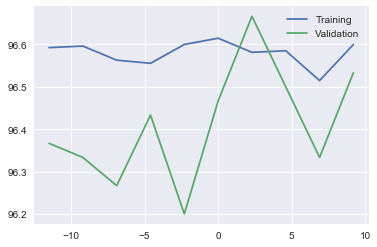

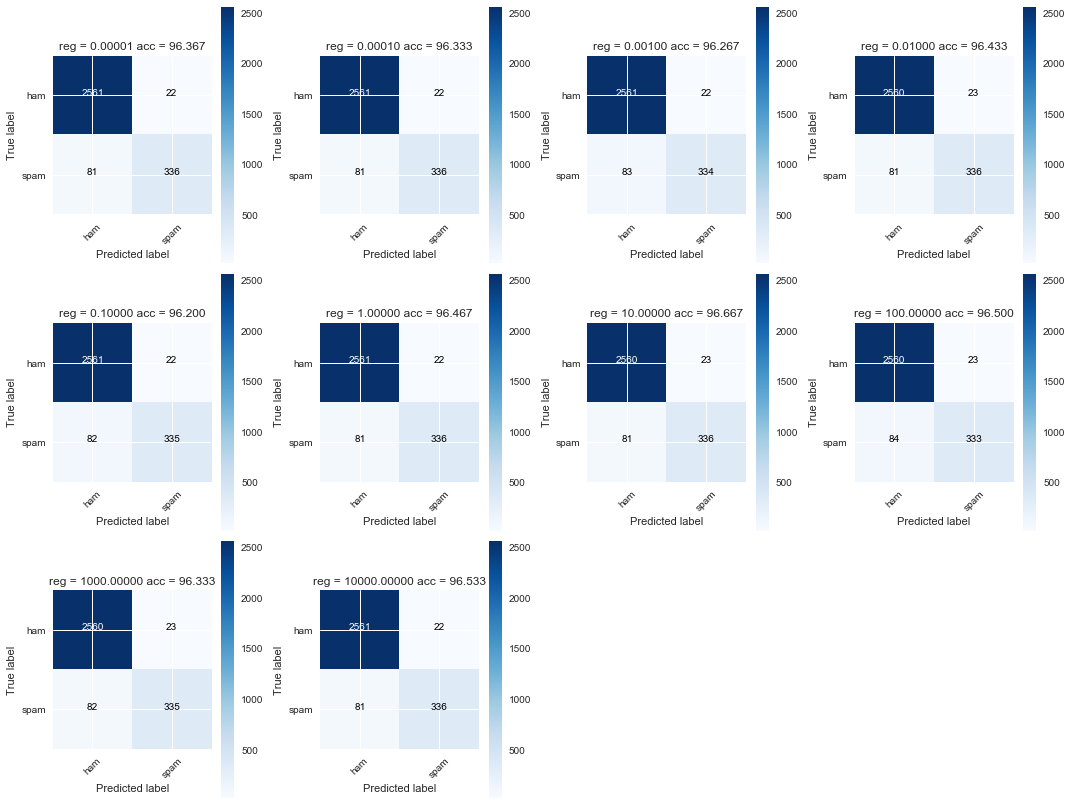

In [20]:
acc_train_kfold = []
acc_test_kfold = []
w_opts = []
import math
reg_list = [pow(10,x) for x in range(-5,5) ]
#reg_list = [pow(10,x) for x in range(2) ]
for reg in reg_list:
	a,b,c = kFolds(10,train,batch_size = 50,n_iters = 10,learning_rate = 0.9, reg = reg) # batch size 50, n_iters = 10
	acc_train_kfold.append(a)
	acc_test_kfold.append(b)
	w_opts.append(c)
### plotting the training and validation performance wrt log (lamda) ###
plt.plot(np.log(reg_list),acc_train_kfold,label = 'Training')
plt.plot(np.log(reg_list),acc_test_kfold,label = 'Validation')
plt.legend()

### plotting the confusion matrix for all lambda values ###
plt.figure(figsize=(15,15))
j=1
for i in range(len(w_opts)):
    ahat = np.dot(train[:,:-1],w_opts[i])
    yhat = sigmoid(ahat)
    plt.subplot(4,4,j)
    j+=1
    for _ in range(yhat.shape[0]):
        if yhat[_,0]>=0.5:
            yhat[_,0] = 1 
        if yhat[_,0]<0.5:
            yhat[_,0] = 0
    cnf_m = confusion_matrix(train[:,-1],yhat)
    plot_confusion_matrix(cnf_m,title = 'reg = %.5f acc = %.3f'%(reg_list[i],acc_test_kfold[i]))
    print("accuracy with reg = %.5f : %.4f"%(reg_list[i],100*metrics.accuracy_score(train[:,-1],yhat)))

Infer something from the graphs above. <br>

Increasing the batch size with all other hyperparameters unchanged.

In [21]:
acc_train_kfold = []
acc_test_kfold = []
w_opts = []
import math
start = time.time()
reg_list = [pow(10,x) for x in range(-5,5) ]
for reg in reg_list:
	a,b,c = kFolds(10,train,batch_size = 500,n_iters = 10,learning_rate = 0.9, reg = reg) # batch size 50, n_iters = 10
	acc_train_kfold.append(a)
	acc_test_kfold.append(b)
	w_opts.append(c)
end = time.time()
#print("time taken : %d seconds"%(end-start))

last fold with 0.00001 reg
last fold with 0.00010 reg
last fold with 0.00100 reg
last fold with 0.01000 reg
last fold with 0.10000 reg
last fold with 1.00000 reg
last fold with 10.00000 reg
last fold with 100.00000 reg
last fold with 1000.00000 reg
last fold with 10000.00000 reg


Confusion matrix, without normalization
[[2560   23]
 [  93  324]]
accuracy with reg = 0.00001 : 96.1333
Confusion matrix, without normalization
[[2560   23]
 [  89  328]]
accuracy with reg = 0.00010 : 96.2667
Confusion matrix, without normalization
[[2561   22]
 [  95  322]]
accuracy with reg = 0.00100 : 96.1000
Confusion matrix, without normalization
[[2561   22]
 [  92  325]]
accuracy with reg = 0.01000 : 96.2000
Confusion matrix, without normalization
[[2557   26]
 [  96  321]]
accuracy with reg = 0.10000 : 95.9333
Confusion matrix, without normalization
[[2561   22]
 [  91  326]]
accuracy with reg = 1.00000 : 96.2333
Confusion matrix, without normalization
[[2562   21]
 [ 101  316]]
accuracy with reg = 10.00000 : 95.9333
Confusion matrix, without normalization
[[2559   24]
 [  92  325]]
accuracy with reg = 100.00000 : 96.1333
Confusion matrix, without normalization
[[2556   27]
 [  87  330]]
accuracy with reg = 1000.00000 : 96.2000
Confusion matrix, without normalization
[[2561   

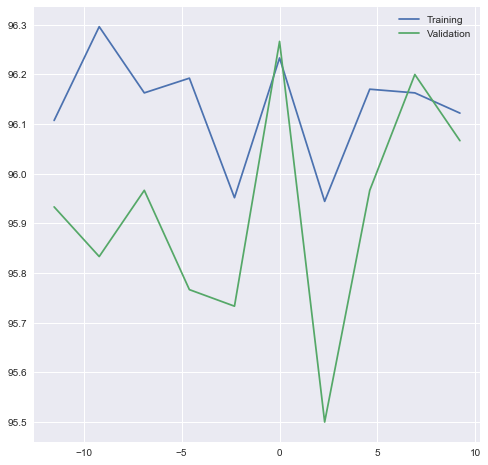

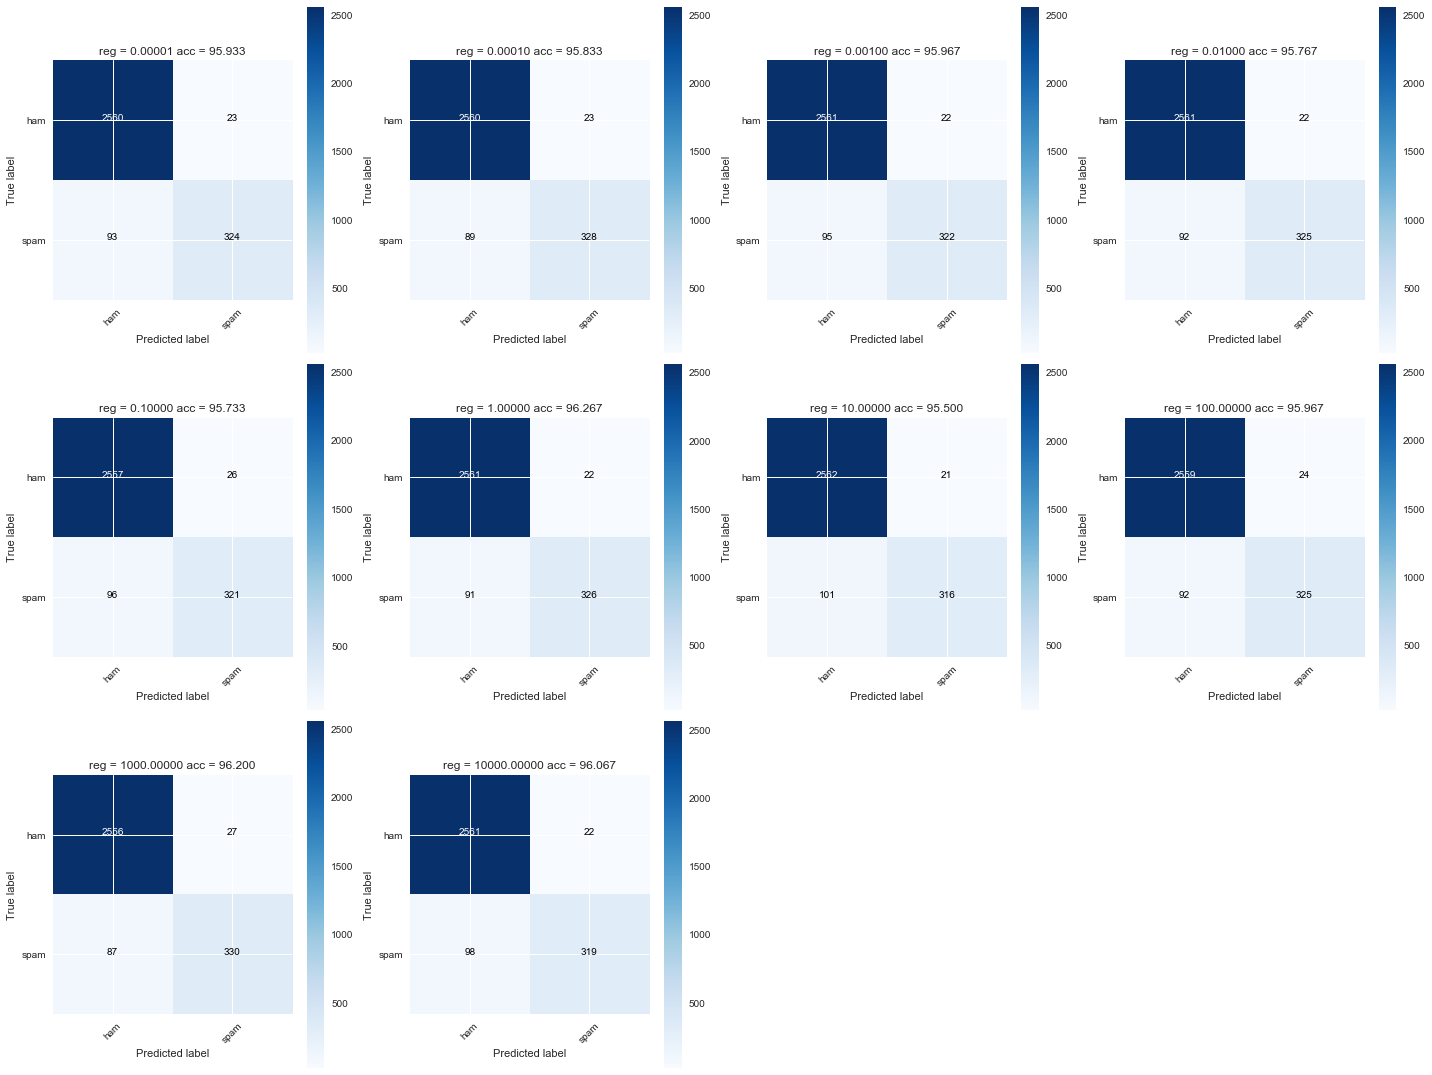

In [22]:
### plotting the training and validation performance wrt log (lamda) ###
plt.figure(figsize=(8,8))
plt.plot(np.log(reg_list),acc_train_kfold,label = 'Training')
plt.plot(np.log(reg_list),acc_test_kfold,label = 'Validation')
plt.legend()

### plotting the confusion matrix for all lambda values ###
plt.figure(figsize=(20,20))
j=1
for i in range(len(w_opts)):
    ahat = np.dot(train[:,:-1],w_opts[i])
    yhat = sigmoid(ahat)
    plt.subplot(4,4,j)
    j+=1
    for _ in range(yhat.shape[0]):
        if yhat[_,0]>=0.5:
            yhat[_,0] = 1 
        if yhat[_,0]<0.5:
            yhat[_,0] = 0
    cnf_m = confusion_matrix(train[:,-1],yhat)
    plot_confusion_matrix(cnf_m,title = 'reg = %.5f acc = %.3f'%(reg_list[i],acc_test_kfold[i]))
    print("accuracy with reg = %.5f : %.4f"%(reg_list[i],100*metrics.accuracy_score(train[:,-1],yhat)))

A lot of interesting things can be done by tuning the hyperparameters which is beyond the scope of this homework. So I will include other results in the last few cells if possible. <br>

# Model Selection wrt $\lambda$: <br>


* Normally, regularizer that gives the highest accuracy on the validation set is used for model selection. <br>
* Additionally, from the insight that confusion matrix gives us, for the problem of spam detection, it is important to detect spam texts/emails correctly but more importantly we need to pick a model that has the least false positive scores. <br> 
* This is because a proper text misclassified as spam will cause in losing valuable information. <br>

Here the accuracies with different regularizes are approximately the same so it is better to go with lowest false positive rate but for the sake of homework I will post the results of using both the models. (In case they are different models.)


Test accuracy with 0.000100 regularizer = 96.6000
Confusion matrix, without normalization
[[2561   22]
 [  80  337]]


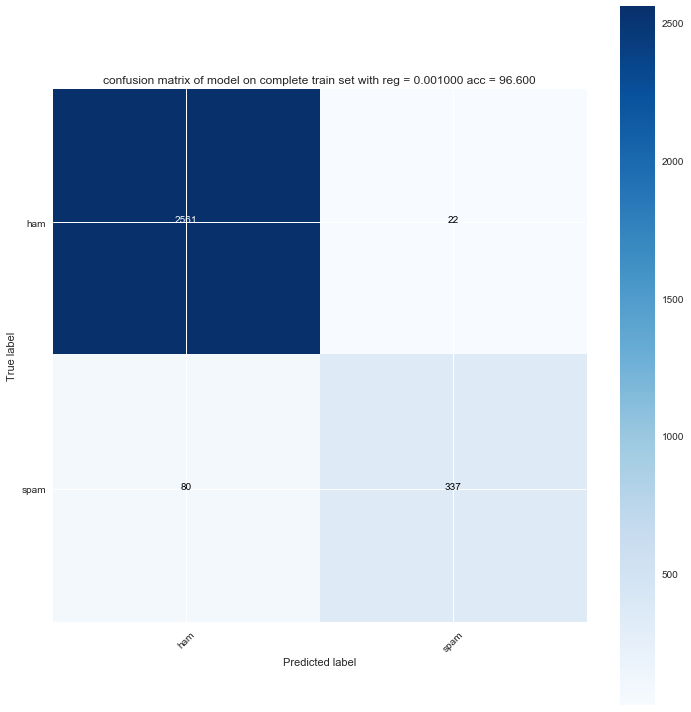

In [23]:
# lambda = 0.001
w_opt_test = w_opts[2]
w_opt_final = bgd_optimizer(n_iters=10,batch_size=50,learning_rate=0.9,w = w_opt_test,matrix = train,reg = 0.01, print_cost = False)[0]
#print(w_opt_final.shape)
yhat_test = sigmoid(np.dot(train[:,:-1],w_opt_final))
yhat_test = predict(yhat_test)
#print(yhat_test.shape)
test_accuracy = 100*metrics.accuracy_score(yhat_test,train[:,-1])
print("Test accuracy with %f regularizer = %.4f"%(reg_list[1],test_accuracy))
##confusion matrix ##
cnf_m = confusion_matrix(train[:,-1],yhat_test)
plt.figure(figsize=(10,10))    
plot_confusion_matrix(cnf_m,title = 'confusion matrix of model on complete train set with reg = %f acc = %.3f'%(reg_list[2],test_accuracy))

By setting batch size hyperparameter to 2700 (which is kfolds-1 * (shape/kfolds) ) in the bgd_optimizer function call we can run batch gradient descent. 

This is because bgd_optimizer is actually minibatch gradient descent and setting the batch size to 1 yields stochastic gradient descent and setting it to number of example in validation set gives batch gradient descent. 

This helps in implementing SGD and minibatch for extra credit without having to rewrite the entire optimizer block.

In [28]:
acc_train_kfold = []
acc_test_kfold = []
w_opts = []
import math
start = time.time()
reg_list = [pow(10,x) for x in range(-5,5) ]
for reg in reg_list:
	a,b,c = kFolds(n_folds = 10,matrix = train,batch_size = int(train.shape[0]/10),n_iters = 10,learning_rate = 0.9, reg = reg) # batch size 50, n_iters = 10
	acc_train_kfold.append(a)
	acc_test_kfold.append(b)
	w_opts.append(c)
end = time.time()
#print("time taken : %d seconds"%(end-start))

last fold with 0.00001 reg
last fold with 0.00010 reg
last fold with 0.00100 reg
last fold with 0.01000 reg
last fold with 0.10000 reg
last fold with 1.00000 reg
last fold with 10.00000 reg
last fold with 100.00000 reg
last fold with 1000.00000 reg
last fold with 10000.00000 reg


Confusion matrix, without normalization
[[2561   22]
 [  89  328]]
accuracy with reg = 0.00001 : 96.3000
Confusion matrix, without normalization
[[2561   22]
 [  90  327]]
accuracy with reg = 0.00010 : 96.2667
Confusion matrix, without normalization
[[2561   22]
 [  89  328]]
accuracy with reg = 0.00100 : 96.3000
Confusion matrix, without normalization
[[2562   21]
 [  89  328]]
accuracy with reg = 0.01000 : 96.3333
Confusion matrix, without normalization
[[2562   21]
 [  89  328]]
accuracy with reg = 0.10000 : 96.3333
Confusion matrix, without normalization
[[2561   22]
 [  89  328]]
accuracy with reg = 1.00000 : 96.3000
Confusion matrix, without normalization
[[2561   22]
 [  90  327]]
accuracy with reg = 10.00000 : 96.2667
Confusion matrix, without normalization
[[2561   22]
 [  89  328]]
accuracy with reg = 100.00000 : 96.3000
Confusion matrix, without normalization
[[2561   22]
 [  89  328]]
accuracy with reg = 1000.00000 : 96.3000
Confusion matrix, without normalization
[[2561   

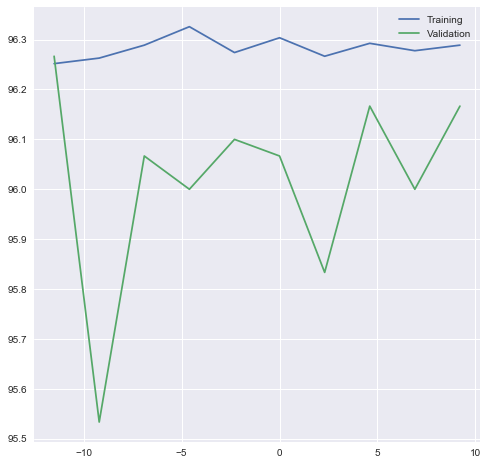

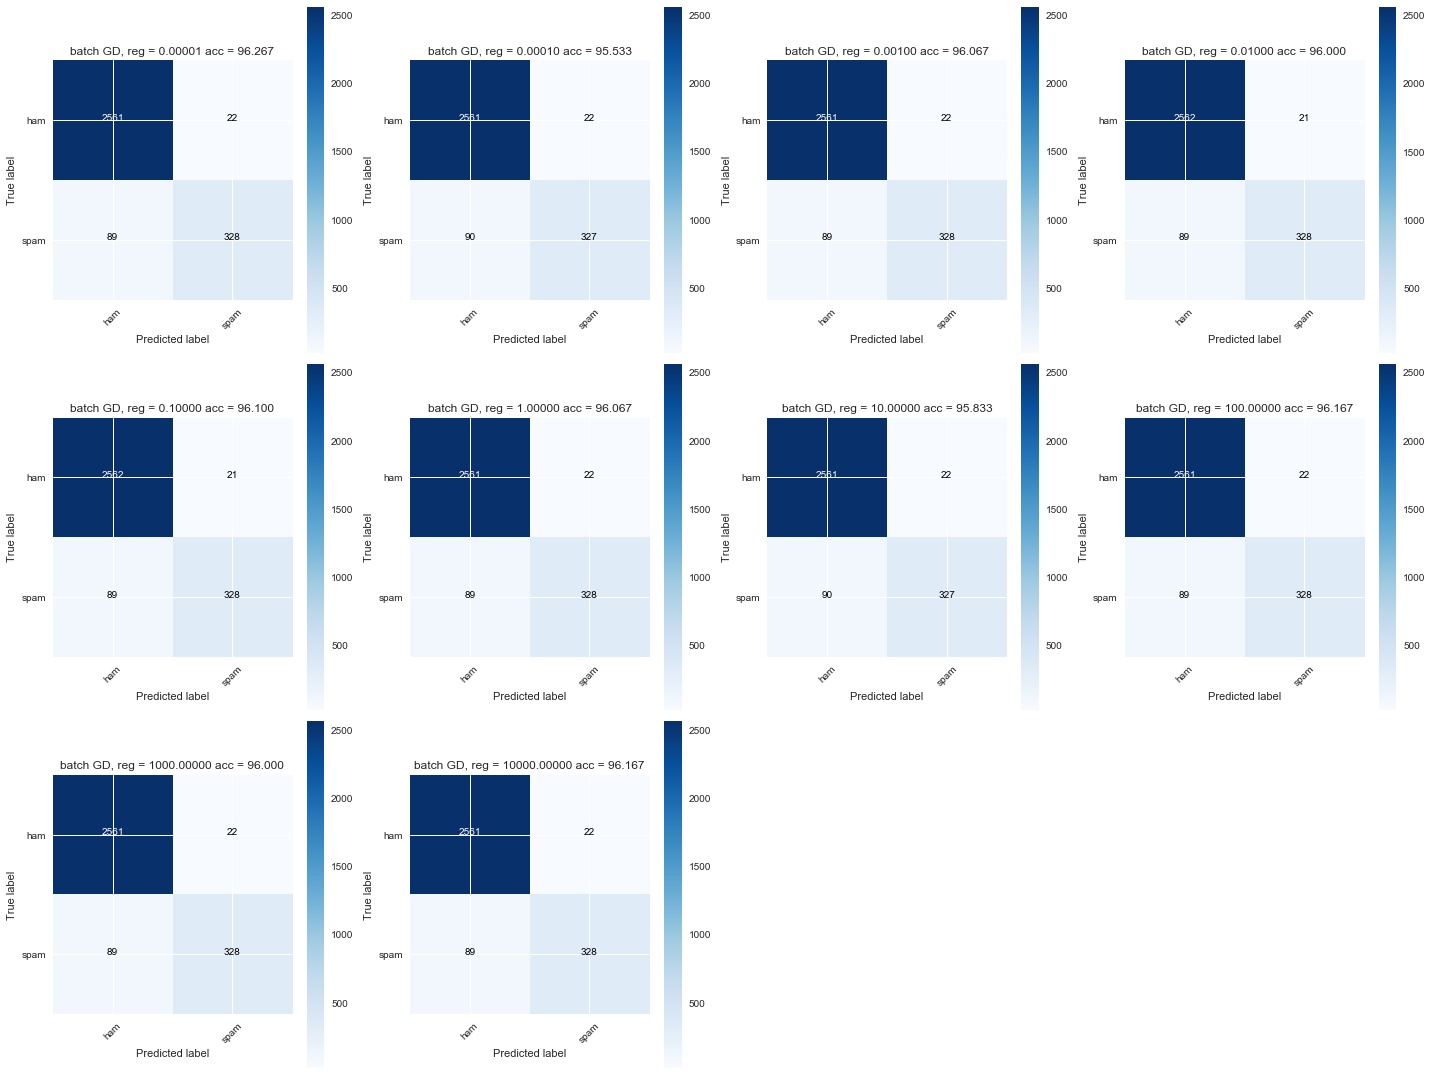

In [29]:
### plotting the training and validation performance wrt log (lamda) ###
plt.figure(figsize=(8,8))
plt.plot(np.log(reg_list),acc_train_kfold,label = 'Training')
plt.plot(np.log(reg_list),acc_test_kfold,label = 'Validation')
plt.legend()

### plotting the confusion matrix for all lambda values ###
plt.figure(figsize=(20,20))
j=1
for i in range(len(w_opts)):
    ahat = np.dot(train[:,:-1],w_opts[i])
    yhat = sigmoid(ahat)
    plt.subplot(4,4,j)
    j+=1
    for _ in range(yhat.shape[0]):
        if yhat[_,0]>=0.5:
            yhat[_,0] = 1 
        if yhat[_,0]<0.5:
            yhat[_,0] = 0
    cnf_m = confusion_matrix(train[:,-1],yhat)
    plot_confusion_matrix(cnf_m,title = 'batch GD, reg = %.5f acc = %.3f'%(reg_list[i],acc_test_kfold[i]))
    print("accuracy with reg = %.5f : %.4f"%(reg_list[i],100*metrics.accuracy_score(train[:,-1],yhat)))

In [31]:
# lambda = 0.01 reg_list[3]

w_opt_test = w_opts[3]
w_opt_final = bgd_optimizer(n_iters=10,batch_size=3000,learning_rate=0.9,w = w_opt_test,matrix = train,reg = 0.01, print_cost = False)[0]
print(w_opt_final.shape)

yhat_test = sigmoid(np.dot(test[:,:-1],w_opt_final))
yhat_test = predict(yhat_test)

#print(yhat_test.shape)
test_accuracy = 100*metrics.accuracy_score(yhat_test,test[:,-1])
print("Test accuracy with %f regularizer = %.4f"%(reg_list[3],test_accuracy))
##confusion matrix ##
cnf_m = confusion_matrix(test[:,-1],yhat_test)
plt.figure(figsize=(10,10))    
plot_confusion_matrix(cnf_m,title = 'confusion matrix of model on complete test set with reg = %f acc = %.3f'%(reg_list[3],test_accuracy))

ZeroDivisionError: division by zero